# Plot and comparisons

In [1]:
library(tidyverse)
library(ggpubr)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
save_plot <- function(p, fn, w=7, h=6){
    for(ext in c(".pdf", ".png", ".svg")){
        ggsave(filename=paste0(fn,ext), plot=p, width=w, height=h)
    }
}


get_ml_summary <- function(fn){
    ml_df = data.table::fread(fn) %>% mutate_at("fold", as.character) %>%
        select(fold, n_features, n_redundant, starts_with("test_score_r2")) %>%
        pivot_longer(-fold) %>% group_by(name) %>%
        summarise(Mean=mean(value), Median=median(value), Std=sd(value), .groups = "keep")
    return(ml_df)
}


get_metrics <- function(filename, tissue){
    datalist = list()
    for(fn in Sys.glob(filename)){
        gene_id = str_extract(fn, "ENSG\\d+_\\d+")
        dat <- get_ml_summary(fn)
        dat["Geneid"] = gene_id
        datalist[[gene_id]] <- dat
    }
    ml_df <- bind_rows(datalist)
    ml_df["Tissue"] = tissue
    return(ml_df)
}

## Load metrics

### RaFFE

In [3]:
filename1 = "../../raffe/_m/caudate/*/raffe_10folds.txt"
filename2 = "../../raffe/_m/dentateGyrus/*/raffe_10folds.txt"
filename3 = "../../raffe/_m/dlpfc/*/raffe_10folds.txt"
filename4 = "../../raffe/_m/hippocampus/*/raffe_10folds.txt"

raffe_cc <- get_metrics(filename1, "Caudate")
raffe_gg <- get_metrics(filename2, "Dentate Gyrus")
raffe_dd <- get_metrics(filename3, "DLPFC")
raffe_hh <- get_metrics(filename4, "Hippocampus")

raffe = bind_rows(raffe_cc, raffe_gg, raffe_dd, raffe_hh) %>%
    as.data.frame %>% mutate_if(is.character, as.factor) %>%
    filter(name == "test_score_r2") %>%
    mutate("Model" = "Random Forest") %>% select(-"name")
dim(raffe)
raffe %>% head(2)

[1] 73  6

,Mean,Median,Std,Geneid,Tissue,Model
,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>
1,-0.1298102,-0.1156836,0.1362887,ENSG00000119004_15,Caudate,Random Forest
2,0.6357395,0.6573027,0.1013178,ENSG00000120071_12,Caudate,Random Forest


### Lasso

In [4]:
filename1 = "../../lasso/_m/caudate/*/lasso_rfe_10folds.txt"
filename2 = "../../lasso/_m/dentateGyrus/*/lasso_rfe_10folds.txt"
filename3 = "../../lasso/_m/dlpfc/*/lasso_rfe_10folds.txt"
filename4 = "../../lasso/_m/hippocampus/*/lasso_rfe_10folds.txt"

lasso_cc <- get_metrics(filename1, "Caudate")
lasso_gg <- get_metrics(filename2, "Dentate Gyrus")
lasso_dd <- get_metrics(filename3, "DLPFC")
lasso_hh <- get_metrics(filename4, "Hippocampus")

lasso = bind_rows(lasso_cc, lasso_gg, lasso_dd, lasso_hh) %>%
    as.data.frame %>% mutate_if(is.character, as.factor) %>%
    filter(name == "test_score_r2") %>%
    mutate("Model" = "Lasso") %>% select(-"name")
dim(lasso)
lasso %>% head(2)

[1] 73  6

,Mean,Median,Std,Geneid,Tissue,Model
,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>
1,-0.03015328,-0.018790764,0.03508347,ENSG00000119004_15,Caudate,Lasso
2,-0.04330435,-0.002339896,0.07923908,ENSG00000120071_12,Caudate,Lasso


### Elastic net

In [5]:
filename1 = "../../enet_v2/_m/caudate/*/enet_rfe_10folds.txt"
filename2 = "../../enet_v2/_m/dentateGyrus/*/enet_rfe_10folds.txt"
filename3 = "../../enet_v2/_m/dlpfc/*/enet_rfe_10folds.txt"
filename4 = "../../enet_v2/_m/hippocampus/*/enet_rfe_10folds.txt"

enet_cc <- get_metrics(filename1, "Caudate")
enet_gg <- get_metrics(filename2, "Dentate Gyrus")
enet_dd <- get_metrics(filename3, "DLPFC")
enet_hh <- get_metrics(filename4, "Hippocampus")

enet = bind_rows(enet_cc, enet_gg, enet_dd, enet_hh) %>%
    as.data.frame %>% mutate_if(is.character, as.factor) %>%
    filter(name == "test_score_r2") %>%
    mutate("Model" = "Elastic Net") %>% select(-"name")
dim(enet)
enet %>% head(2)

[1] 73  6

,Mean,Median,Std,Geneid,Tissue,Model
,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>
1,-0.2974681,-0.1282239,0.4870693,ENSG00000119004_15,Caudate,Elastic Net
2,0.5639279,0.5362865,0.1342726,ENSG00000120071_12,Caudate,Elastic Net


### Partial R2

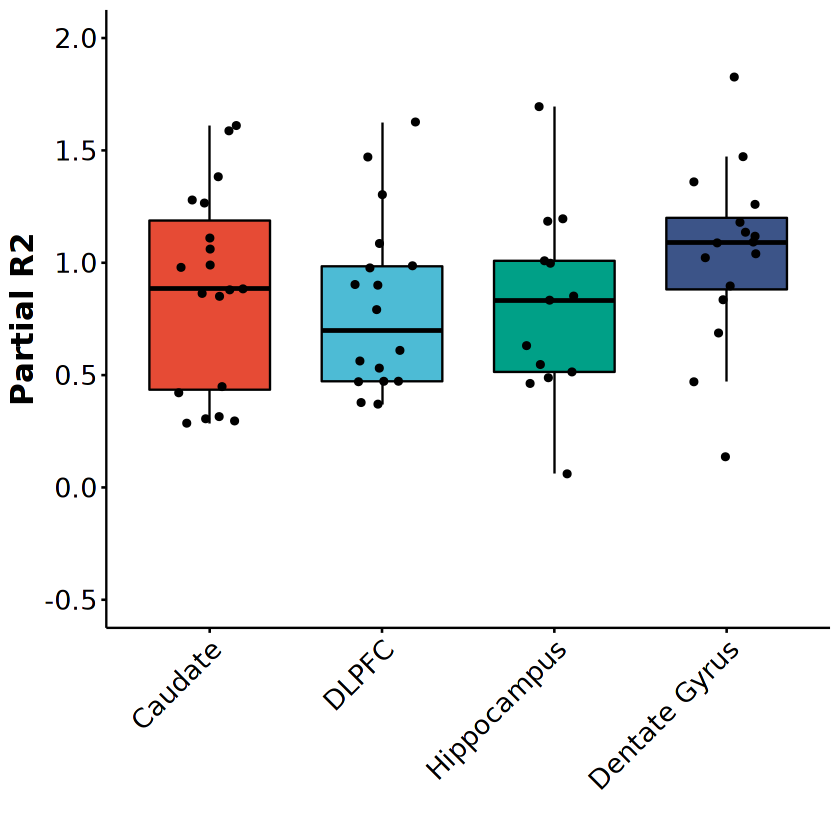

In [6]:
dx = data.table::fread("../../partial_r2/_m/partial_r2_genotypes_raffeSNPs.tsv")

bxp = dx %>% filter(Partial_R2 < 2) %>%
    ggboxplot(x="Tissue", y="Partial_R2", fill="Tissue", add="jitter", 
              palette="npg", xlab="", ylab="Partial R2", legend="None", 
              ylim=c(-0.5, 2), panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
save_plot(bxp, "summary_boxplots_partial_r2", 5, 5)
bxp

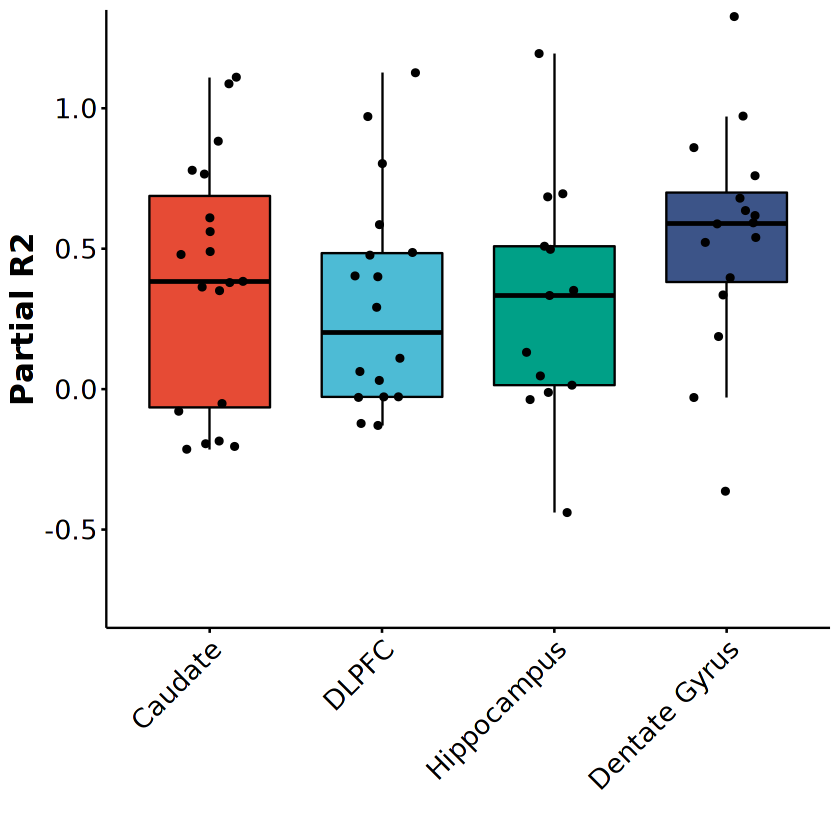

In [8]:
#dx = data.table::fread("../../partial_r2/_m/partial_r2_genotypes_raffeSNPs.tsv")
bxp = dx %>% mutate(partialr2 = Partial_R2 - 0.5) %>% filter(Partial_R2 < 2) %>%
    ggboxplot(x="Tissue", y="partialr2", fill="Tissue", add="jitter", 
              palette="npg", xlab="", ylab="Partial R2", legend="None", 
              ylim=c(-0.75, 1.25), panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
save_plot(bxp, "summary_boxplots_partial_r2_zeroed", 5, 5)
bxp

## Merge and plot

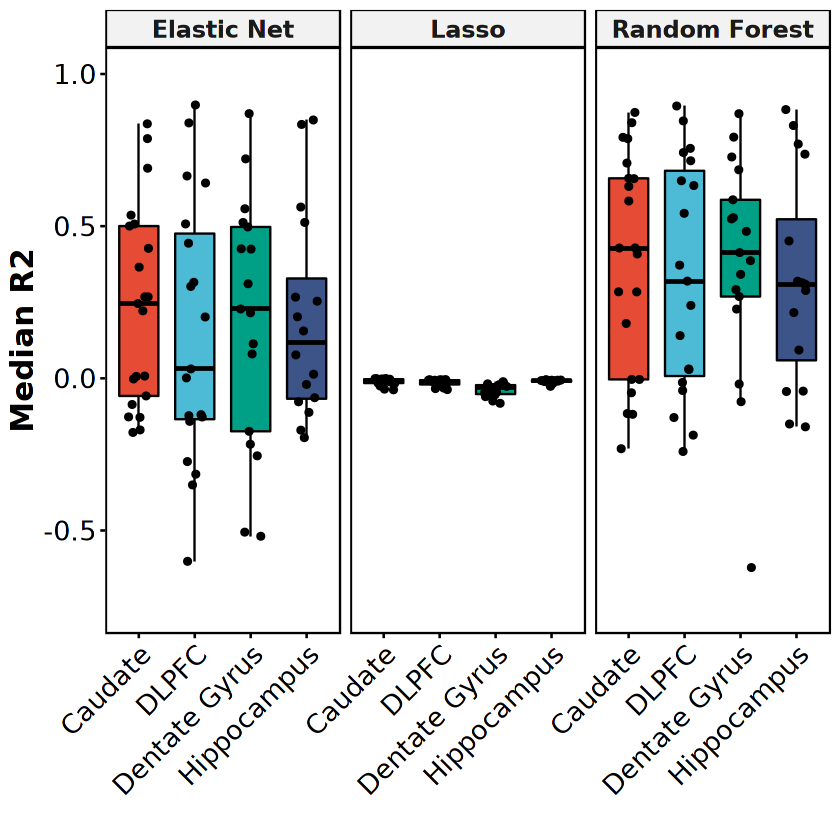

In [8]:
df = bind_rows(raffe, lasso, enet)
bxp = df %>% ggboxplot(x="Tissue", y="Median", fill="Tissue", add="jitter", 
                       facet.by="Model", palette="npg", ylim=c(-0.75, 1), 
                       ylab="Median R2", xlab="", legend="None", 
                       panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
save_plot(bxp, "summary_boxplots_r2_3methods", 9, 6)
bxp

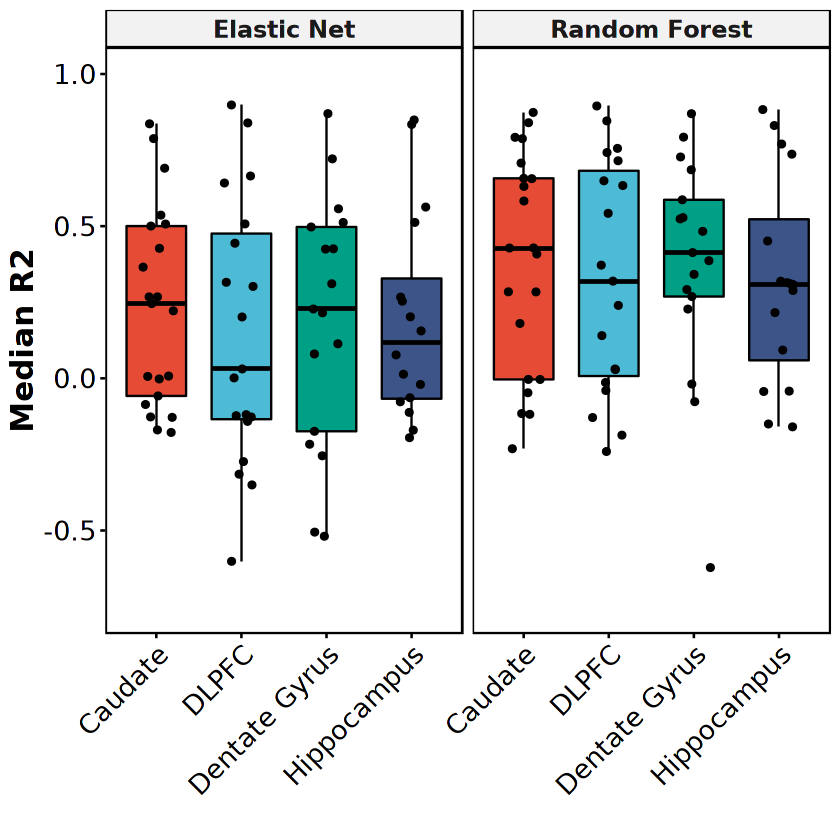

In [10]:
df = bind_rows(raffe, enet)
bxp = df %>% ggboxplot(x="Tissue", y="Median", fill="Tissue", add="jitter", 
                       facet.by="Model", palette="npg", ylim=c(-0.75, 1), 
                       ylab="Median R2", xlab="", legend="None", 
                       panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
save_plot(bxp, "summary_boxplots_r2_2methods", 6, 5)
bxp

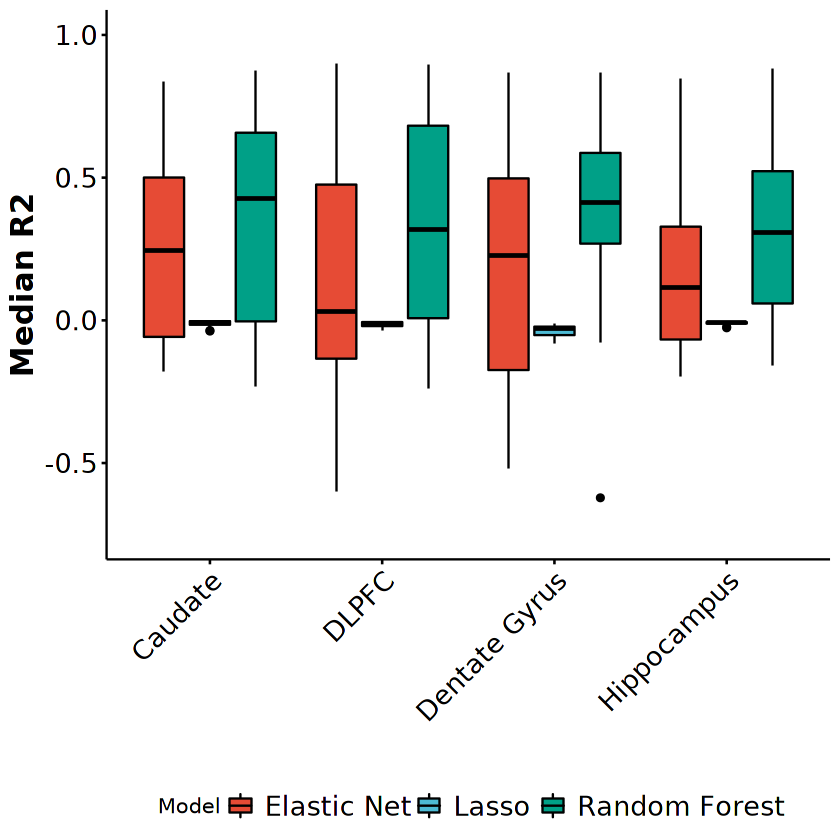

In [18]:
df = bind_rows(raffe, lasso, enet)
bxp = df %>% ggboxplot(x="Tissue", y="Median", fill="Model", 
                       palette="npg", ylim=c(-0.75, 1), 
                       ylab="Median R2", xlab="", legend="bottom", 
                       panel.labs.font=list(face='bold', size = 14)) + 
    rotate_x_text(45) + font("xy.title", size=18, face="bold") + 
    font("xy.text", size=16) + font("legend.text", size=16)
#save_plot(bxp, "summary_boxplots_r2_2methods_stacked", 6, 5)
bxp

## Reproducibility Information

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()